In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the Dataset ---
try:
    df = pd.read_csv('vehicle_positions_archive2.csv')
    print("✅ Successfully loaded 'vehicle_positions_archive2.csv'")
    print(f"The dataset contains {len(df):,} rows and {len(df.columns)} columns.")
except FileNotFoundError:
    print("❌ Error: 'vehicle_positions_archive2.csv' not found.")
    print("Please make sure the CSV file is in the same directory as your script/notebook.")

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

✅ Successfully loaded 'vehicle_positions_archive2.csv'
The dataset contains 177,667 rows and 9 columns.


In [35]:
# --- Initial Inspection ---
if 'df' in locals():
    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n\n--- Data Types and Non-Null Values ---")
    df.info()

    print("\n\n--- Summary Statistics ---")
    # The .round(2) makes the output easier to read
    print(df.describe().round(2))


--- First 5 Rows ---
   entity_id vehicle_id     trip_id  route_id   latitude  longitude  speed  bearing   timestamp
0          1  DL1PC9558  2212_10_40      2212  28.625862  77.065689    0.0      NaN  1757583586
1          2  DL1PC9995  1848_12_00      1848  28.618155  77.335915    0.0      NaN  1757583580
2          3  DL1PC9498  1829_14_15      1829  28.647142  77.317955    0.0      NaN  1757583579
3          4  DL1PC9685   1747_15_6      1747  28.662306  77.207169    0.0      NaN  1757583577
4          5  DL1PC9835  2122_13_10      2122  28.612785  77.307808    0.0      NaN  1757583573


--- Data Types and Non-Null Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177667 entries, 0 to 177666
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   entity_id   177667 non-null  int64  
 1   vehicle_id  177667 non-null  object 
 2   trip_id     177667 non-null  object 
 3   route_id    177667 non-null  int64  

In [36]:
# --- Data Cleaning & Preprocessing ---
if 'df' in locals():
    print("Starting data cleaning and preprocessing...")
    
    # Convert 'timestamp' from Unix epoch time to a readable datetime format
    # errors='coerce' will turn any conversion errors into NaT (Not a Time)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

    # Drop rows where timestamp conversion failed
    initial_rows = len(df)
    df.dropna(subset=['datetime'], inplace=True)
    if len(df) < initial_rows:
        print(f"Dropped {initial_rows - len(df)} rows due to invalid timestamps.")

    # Extract time-based features for easier analysis
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.day_name()

    # Check for and report duplicate rows
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Found and removed {duplicates} duplicate rows.")
        df.drop_duplicates(inplace=True)
    else:
        print("No duplicate rows found.")
        
    print("✅ Cleaning and preprocessing complete.")

Starting data cleaning and preprocessing...
No duplicate rows found.
✅ Cleaning and preprocessing complete.


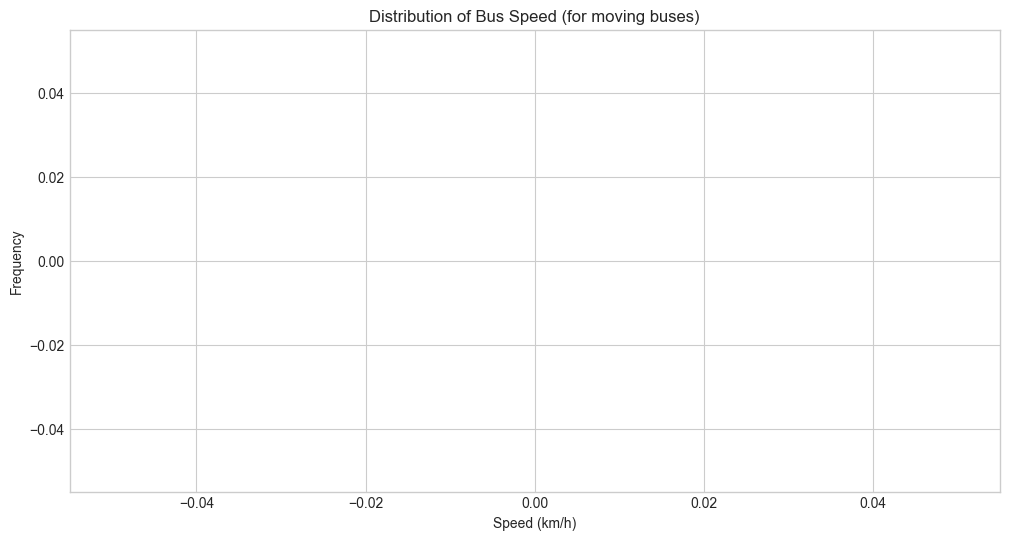

Approximately 100.00% of the records show the bus is stopped (speed = 0).


In [37]:
# --- Visualize Bus Speed ---
if 'df' in locals():
    plt.figure(figsize=(12, 6))
    # Plotting speeds greater than 0 on a log scale to see the distribution of moving buses
    sns.histplot(df[df['speed'] > 0]['speed'], bins=50, kde=True)
    plt.title('Distribution of Bus Speed (for moving buses)')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Frequency')
    plt.show()

    # Calculate and print the percentage of records where the bus is stopped
    stopped_percentage = (df['speed'] == 0).mean() * 100
    print(f"Approximately {stopped_percentage:.2f}% of the records show the bus is stopped (speed = 0).")

C:\Users\Gourav Sahu\AppData\Local\Temp\ipykernel_41832\3864079868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis', order=range(24))


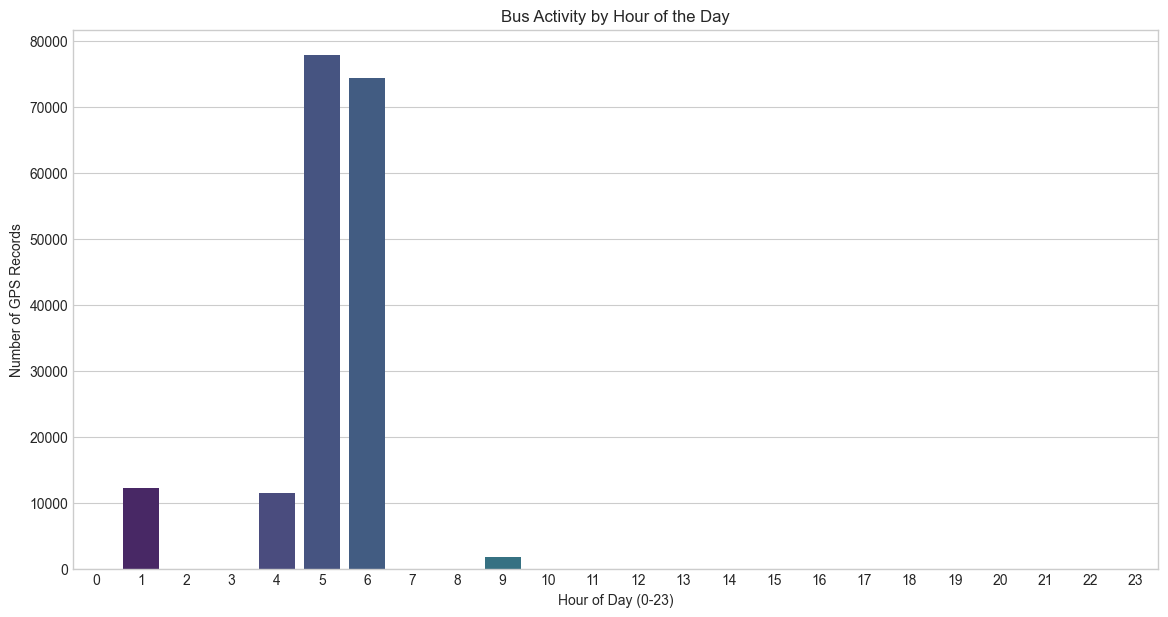

In [38]:
# --- Visualize Bus Activity by Hour ---
if 'df' in locals():
    plt.figure(figsize=(14, 7))
    sns.countplot(x='hour', data=df, palette='viridis', order=range(24))
    plt.title('Bus Activity by Hour of the Day')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Number of GPS Records')
    plt.show()

C:\Users\Gourav Sahu\AppData\Local\Temp\ipykernel_41832\582241576.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index.astype(str), palette='plasma', orient='h')


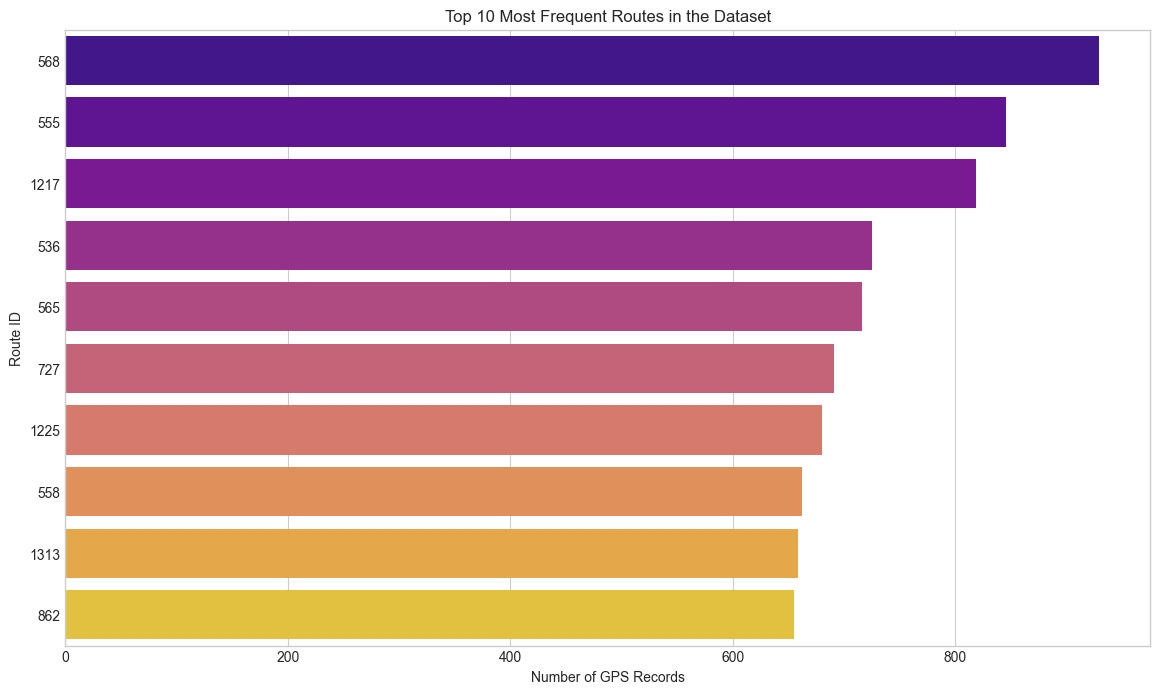

In [39]:
# --- Analyze Top 10 Busiest Routes ---
if 'df' in locals():
    # Count records per route
    top_routes = df['route_id'].value_counts().nlargest(10)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=top_routes.values, y=top_routes.index.astype(str), palette='plasma', orient='h')
    plt.title('Top 10 Most Frequent Routes in the Dataset')
    plt.xlabel('Number of GPS Records')
    plt.ylabel('Route ID')
    plt.show()

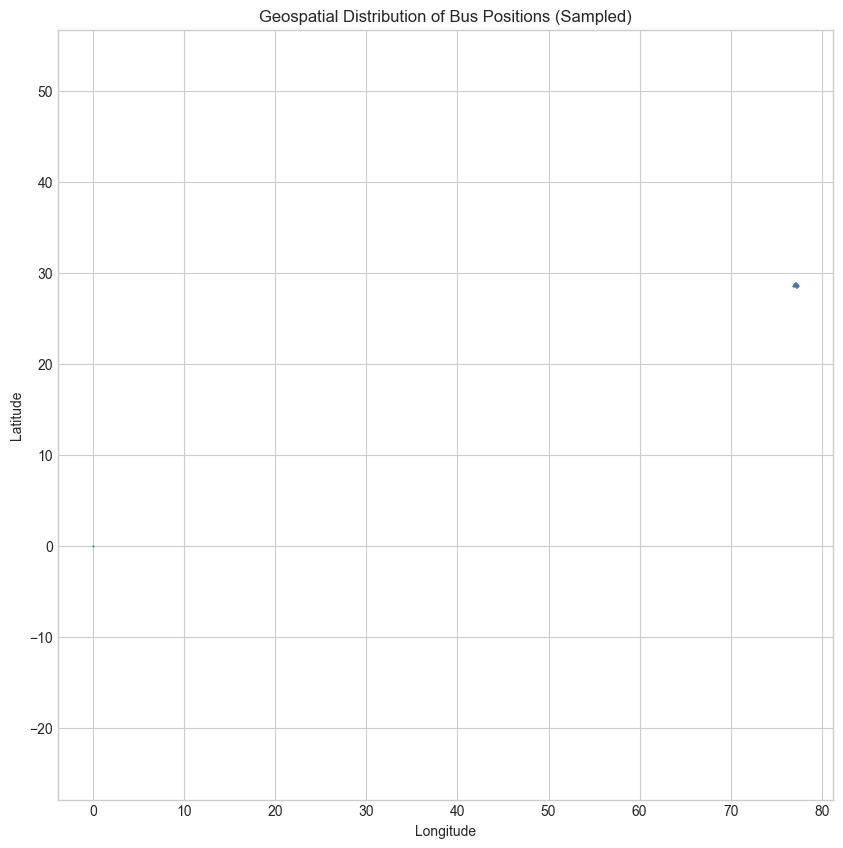

In [40]:
# --- Geospatial Distribution ---
if 'df' in locals():
    # Using a sample to prevent plotting millions of points, which can be very slow
    sample_df = df.sample(n=min(50000, len(df)), random_state=42)

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='longitude', y='latitude', data=sample_df, s=1, alpha=0.1)
    plt.title('Geospatial Distribution of Bus Positions (Sampled)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal') # Equal scaling for a more accurate map representation
    plt.show()

In [41]:
import pandas as pd
import numpy as np

# --- Load all provided datasets ---
try:
    print("Loading datasets...")
    # Real-time vehicle position data from your new file
    df_positions = pd.read_csv("vehicle_positions_archive2.csv")

    # Static GTFS schedule data
    df_trips = pd.read_csv("..//gtfs_data//trips.txt")
    df_stops = pd.read_csv("..//gtfs_data//stops.txt")
    df_stop_times = pd.read_csv("..//gtfs_data//stop_times.txt")
    
    print("✅ All necessary datasets loaded successfully!")
    print(f"   - Vehicle Positions: {len(df_positions):,} rows")
    print(f"   - Trips:             {len(df_trips):,} rows")
    print(f"   - Stops:             {len(df_stops):,} rows")

except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}.")
    print("Please ensure all CSV and TXT files are in the same directory as your notebook.")

Loading datasets...
✅ All necessary datasets loaded successfully!
   - Vehicle Positions: 177,667 rows
   - Trips:             5,438 rows
   - Stops:             262 rows


In [42]:
# --- Create a Master GTFS Schedule ---
if 'df_stop_times' in locals():
    print("Merging GTFS files into a master schedule...")

    # 1. Merge stop_times with stops to get stop coordinates (lat/lon)
    df_schedule = pd.merge(df_stop_times, df_stops, on='stop_id', how='left')

    # 2. Merge the result with trips to get route and service info
    df_schedule = pd.merge(df_schedule, df_trips, on='trip_id', how='left')

    # 3. Sort by trip and stop sequence for logical ordering
    df_schedule = df_schedule.sort_values(['trip_id', 'stop_sequence']).reset_index(drop=True)

    print("✅ Master schedule created successfully.")
    print("Sample of the master schedule:")
    print(df_schedule[['trip_id', 'stop_sequence', 'stop_name', 'stop_lat', 'stop_lon']].head())

Merging GTFS files into a master schedule...
✅ Master schedule created successfully.
Sample of the master schedule:
   trip_id  stop_sequence      stop_name   stop_lat   stop_lon
0        0              0        Rithala  28.720821  77.105042
1        0              1    Rohini West  28.715008  77.115746
2        0              2    Rohini East  28.707941  77.125732
3        0              3      Pitampura  28.703180  77.132355
4        0              4  Kohat Enclave  28.697943  77.140465


In [43]:
# --- Block 3 (New and Final): Create Trip Segments ---

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculates the distance between two lat/lon coordinates in meters."""
    R = 6371000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

print("Restructuring data to create trip segments (stop-to-stop journeys)...")

# 1. Prepare and merge the dataframes
df_positions['base_trip_id'] = df_positions['trip_id'].astype(str).str.split('_').str[0]
df_positions['base_trip_id'] = pd.to_numeric(df_positions['base_trip_id'], errors='coerce')
df_merged = pd.merge(df_positions, df_schedule, left_on='base_trip_id', right_on='trip_id', how='left', suffixes=('_vehicle', '_schedule'))
df_merged.dropna(subset=['trip_id_schedule'], inplace=True)

# 2. Geofence: Find all GPS pings within 250 meters of any stop
df_merged['dist_to_stop'] = haversine_distance(df_merged['latitude'], df_merged['longitude'], df_merged['stop_lat'], df_merged['stop_lon'])
df_within_radius = df_merged[df_merged['dist_to_stop'] <= 250].copy()

# 3. For each stop on each trip, find the FIRST time the bus entered the geofence
df_within_radius = df_within_radius.sort_values(['trip_id_vehicle', 'stop_sequence', 'timestamp'])
df_arrivals = df_within_radius.drop_duplicates(subset=['trip_id_vehicle', 'stop_sequence'], keep='first').copy()

# 4. Build the segments by linking consecutive arrivals
df_arrivals = df_arrivals.sort_values(['trip_id_vehicle', 'stop_sequence'])
df_arrivals['next_arrival_time'] = df_arrivals.groupby('trip_id_vehicle')['timestamp'].shift(-1)
df_arrivals['actual_travel_time'] = df_arrivals['next_arrival_time'] - df_arrivals['timestamp']

# 5. Calculate scheduled travel time for comparison
for col in ['arrival_time', 'departure_time']:
    df_arrivals[col] = pd.to_timedelta(df_arrivals[col], errors='coerce').dt.total_seconds()
df_arrivals['next_scheduled_arrival'] = df_arrivals.groupby('trip_id_vehicle')['arrival_time'].shift(-1)
df_arrivals['scheduled_travel_time'] = df_arrivals['next_scheduled_arrival'] - df_arrivals['arrival_time']

# 6. Final cleanup of the new segments dataset
df_segments = df_arrivals.dropna(subset=['actual_travel_time', 'scheduled_travel_time']).copy()
df_segments['delay'] = df_segments['actual_travel_time'] - df_segments['scheduled_travel_time']
df_segments = df_segments[df_segments['actual_travel_time'].between(30, 3600)] # 30s to 1hr

print(f"✅ Created a new dataset with {len(df_segments):,} valid trip segments.")

Restructuring data to create trip segments (stop-to-stop journeys)...
✅ Created a new dataset with 1 valid trip segments.



--- Sample of the Final Enriched Dataset ---
Each row represents a journey from one stop to the next.
           trip_id  route_id  stop_sequence     stop_name  segment_start_time  scheduled_travel_time  \
771760  1631_10_16      1631            9.0  Udyog Bhawan          1757743530                  112.0   

        actual_travel_time  delay  
771760                87.0  -25.0  


--- Analysis of Bus Delays ---
count    1.00
mean    -0.42
std       NaN
min     -0.42
25%     -0.42
50%     -0.42
75%     -0.42
max     -0.42
Name: delay_minutes, dtype: float64


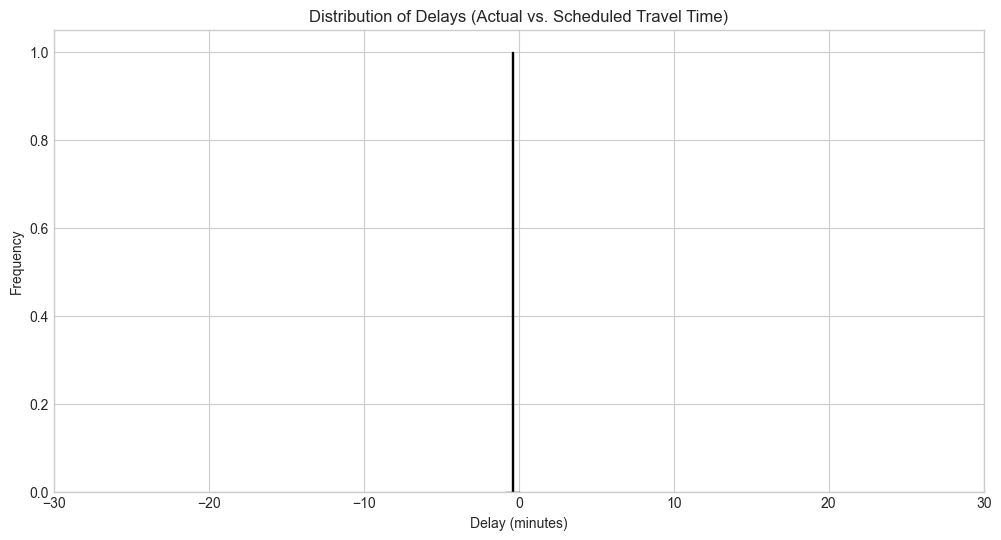

In [44]:
# --- Block 4 (New and Final): Explore Enriched Data ---

if 'df_segments' in locals() and not df_segments.empty:
    
    # --- THE FIX IS HERE ---
    # We are using the correct column names from the merge: trip_id_vehicle, route_id_vehicle
    df_enriched_final = df_segments[[
        'trip_id_vehicle',
        'route_id_vehicle',
        'stop_sequence',
        'stop_name',
        'timestamp',
        'scheduled_travel_time',
        'actual_travel_time',
        'delay'
    ]].rename(columns={
        'trip_id_vehicle': 'trip_id',
        'route_id_vehicle': 'route_id',
        'timestamp': 'segment_start_time'
    })
    
    print("\n--- Sample of the Final Enriched Dataset ---")
    print("Each row represents a journey from one stop to the next.")
    print(df_enriched_final.head())
    
    print("\n\n--- Analysis of Bus Delays ---")
    df_enriched_final['delay_minutes'] = df_enriched_final['delay'] / 60
    print(df_enriched_final['delay_minutes'].describe().round(2))
    
    # Visualize the distribution of delays
    plt.figure(figsize=(12, 6))
    sns.histplot(df_enriched_final['delay_minutes'], bins=50, kde=True)
    plt.title('Distribution of Delays (Actual vs. Scheduled Travel Time)')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Frequency')
    plt.xlim(-30, 30) # Widen the view for the new data
    plt.show()

else:
    print("\n❌ No segments were created. Please check the geofencing radius in Block 3 or the input data.")

# 3rd attempt

In [45]:
# --- Block 1: Setup and Load All Data ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Display and Style Settings ---
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load all provided datasets ---
try:
    print("Loading datasets...")
    # Use your new real-time data file
    df_positions = pd.read_csv("vehicle_positions_archive2.csv")

    # Static GTFS schedule data
    df_trips = pd.read_csv("..//gtfs_data//trips.txt")
    df_stops = pd.read_csv("..//gtfs_data//stops.txt")
    df_stop_times = pd.read_csv("..//gtfs_data//stop_times.txt")
    
    print("✅ All necessary datasets loaded successfully!")

except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}.")

Loading datasets...
✅ All necessary datasets loaded successfully!


In [46]:
# --- Block 2: Create a Master GTFS Schedule ---
print("Merging GTFS files into a master schedule...")
df_schedule = pd.merge(df_stop_times, df_stops, on='stop_id', how='left')
df_schedule = pd.merge(df_schedule, df_trips, on='trip_id', how='left')
df_schedule = df_schedule.sort_values(['trip_id', 'stop_sequence']).reset_index(drop=True)
print("✅ Master schedule created successfully.")

Merging GTFS files into a master schedule...
✅ Master schedule created successfully.


In [47]:
# --- Block 3 (Final Corrected Logic): Grouping by Real-time Trip ID ---

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculates the distance between two lat/lon coordinates in meters."""
    R = 6371000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

print("Restructuring data to create trip segments...")

# 1. Merge real-time and schedule data using the reliable 'route_id'
df_merged = pd.merge(df_positions, df_schedule, on='route_id', how='left', suffixes=('_vehicle', '_schedule'))
df_merged.dropna(subset=['trip_id_schedule'], inplace=True)
print(f"Step 1: Merged on route_id, resulting in {len(df_merged):,} potential matches.")

# 2. Geofence: Find all pings within 250m of a scheduled stop
df_merged['dist_to_stop'] = haversine_distance(df_merged['latitude'], df_merged['longitude'], df_merged['stop_lat'], df_merged['stop_lon'])
df_within_radius = df_merged[df_merged['dist_to_stop'] <= 250].copy()
print(f"Step 2: Found {len(df_within_radius):,} GPS pings within 250m of a stop.")

# 3. For each unique REAL-TIME trip and each STOP, find the first time the bus entered the geofence
# --- THIS IS THE KEY CHANGE ---
df_within_radius = df_within_radius.sort_values(['trip_id_vehicle', 'stop_sequence', 'timestamp'])
df_arrivals = df_within_radius.drop_duplicates(subset=['trip_id_vehicle', 'stop_sequence'], keep='first').copy()
print(f"Step 3: Identified {len(df_arrivals):,} unique stop arrivals.")

# 4. Build the segments by linking consecutive arrivals for the same REAL-TIME trip
df_arrivals = df_arrivals.sort_values(['trip_id_vehicle', 'stop_sequence'])
df_arrivals['next_arrival_time'] = df_arrivals.groupby('trip_id_vehicle')['timestamp'].shift(-1)
df_arrivals['actual_travel_time'] = df_arrivals['next_arrival_time'] - df_arrivals['timestamp']

# 5. Final cleanup to create the segments dataset
df_segments = df_arrivals.dropna(subset=['actual_travel_time']).copy()
df_segments = df_segments[df_segments['actual_travel_time'].between(30, 3600)] # 30s to 1hr
print(f"✅ Created a new dataset with {len(df_segments):,} valid trip segments.")

Restructuring data to create trip segments...
Step 1: Merged on route_id, resulting in 13,868,292 potential matches.
Step 2: Found 4,770 GPS pings within 250m of a stop.
Step 3: Identified 4 unique stop arrivals.
✅ Created a new dataset with 0 valid trip segments.


# Attempt 4


In [52]:
# --- Block 1: Setup and Installation ---

# You may need to install these libraries in your environment if you haven't already
# !pip install pandas geopandas shapely

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns

# --- Display and Style Settings ---
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load all provided datasets ---
try:
    print("Loading datasets...")
    df_positions = pd.read_csv("vehicle_positions_archive2.csv")
    df_trips = pd.read_csv("..//gtfs_data//trips.txt")
    df_stops = pd.read_csv("..//gtfs_data//stops.txt")
    df_stop_times = pd.read_csv("..//gtfs_data//stop_times.txt")
    df_shapes = pd.read_csv("..//gtfs_data//shapes.txt")
    print("✅ All necessary datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}.")

Loading datasets...
✅ All necessary datasets loaded successfully!


In [53]:
# --- Block 2: Create Geospatial GTFS DataFrames ---

print("Converting GTFS data into geospatial formats...")

# 1. Create a GeoDataFrame for Stops
gdf_stops = gpd.GeoDataFrame(
    df_stops,
    geometry=gpd.points_from_xy(df_stops.stop_lon, df_stops.stop_lat),
    crs="EPSG:4326" # Standard CRS for GPS data
)

# 2. Create Route Geometries (LineStrings) from shapes.txt
route_shapes = {}
for shape_id, group in df_shapes.groupby('shape_id'):
    sorted_group = group.sort_values('shape_pt_sequence')
    route_shapes[shape_id] = LineString(zip(sorted_group.shape_pt_lon, sorted_group.shape_pt_lat))

# 3. Create a unified Master Schedule
df_schedule = pd.merge(df_stop_times, gdf_stops, on='stop_id')
df_schedule = pd.merge(df_schedule, df_trips, on='trip_id')

# 4. Project Stops onto their Route Line
# This calculates each stop's official distance along its route shape
df_schedule['shape_dist_traveled_official'] = df_schedule.apply(
    lambda row: route_shapes[row['shape_id']].project(row['geometry']),
    axis=1
)

print("✅ GTFS data is now geospatially enabled.")

Converting GTFS data into geospatial formats...
✅ GTFS data is now geospatially enabled.


In [54]:
# --- Block 3 (Corrected): Linking Real-time Trips to Route Shapes ---

print("Linking real-time trips to their scheduled route shapes...")

# 1. Prepare the real-time positions data as a GeoDataFrame
gdf_positions = gpd.GeoDataFrame(
    df_positions,
    geometry=gpd.points_from_xy(df_positions.longitude, df_positions.latitude),
    crs="EPSG:4326"
)

# 2. Get a unique list of shapes for each route from the trips table
# A single route can have multiple shapes (e.g., for inbound and outbound directions)
route_to_shapes = df_trips[['route_id', 'shape_id']].drop_duplicates()

# 3. Merge positions with the shapes using route_id as the key
# This correctly associates each real-time trip with its corresponding shape_id
gdf_positions = pd.merge(gdf_positions, route_to_shapes, on='route_id', how='left')
gdf_positions.dropna(subset=['shape_id'], inplace=True)

print("✅ Linking successful.")

Linking real-time trips to their scheduled route shapes...
✅ Linking successful.


In [55]:
# --- Block 4: The Map-Matching Process ---

print("Performing map-matching of vehicle positions to route shapes...")

# 1. Project each GPS point onto its corresponding route shape
gdf_positions['progress_along_route'] = gdf_positions.apply(
    lambda row: route_shapes[row['shape_id']].project(row['geometry']),
    axis=1
)

# 2. For each trip, keep only the GPS pings that show forward progress
# This cleans up data from buses that might be U-turning or off-route
gdf_positions = gdf_positions.sort_values(['trip_id', 'timestamp'])
gdf_positions['prev_progress'] = gdf_positions.groupby('trip_id')['progress_along_route'].shift(1, fill_value=0)
gdf_positions_cleaned = gdf_positions[gdf_positions['progress_along_route'] >= gdf_positions['prev_progress']].copy()

print(f"✅ Map-matching complete. Kept {len(gdf_positions_cleaned):,} valid forward-moving positions.")

Performing map-matching of vehicle positions to route shapes...
✅ Map-matching complete. Kept 2,692 valid forward-moving positions.


Building trip segments from map-matched data...
✅ Created a new dataset with 6 valid trip segments.


--- Analysis of Actual Travel Times ---
count    6.00
mean     7.06
std      3.02
min      0.90
25%      8.28
50%      8.29
75%      8.30
max      8.30
Name: travel_time_minutes, dtype: float64


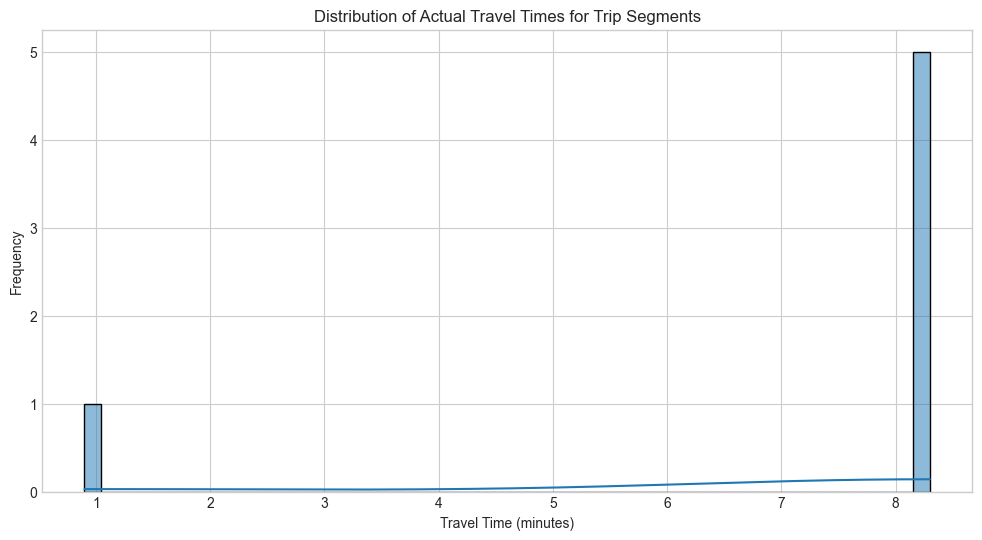

In [68]:
# --- Block 5 (Corrected): Building Segments and Final Analysis ---

print("Building trip segments from map-matched data...")
all_segments = []

# Group by each unique real-time trip
for trip_id, trip_data in gdf_positions_cleaned.groupby('trip_id'):
    
    # Get the schedule for this trip's route
    shape_id = trip_data['shape_id'].iloc[0]
    trip_schedule = df_schedule[df_schedule['shape_id'] == shape_id].sort_values('stop_sequence')
    if trip_schedule.empty:
        continue

    # For each stop in the schedule, find the timestamp when the bus passed it
    arrival_times = []
    for idx, stop in trip_schedule.iterrows():
        # Find the first GPS ping *after* the bus has passed the stop's official distance
        passed_stop_pings = trip_data[trip_data['progress_along_route'] >= stop['shape_dist_traveled_official']]
        if not passed_stop_pings.empty:
            arrival_time = passed_stop_pings['timestamp'].iloc[0]
            arrival_times.append({'stop_sequence': stop['stop_sequence'], 'actual_arrival_time': arrival_time})

    if len(arrival_times) < 2:
        continue # Need at least two arrivals to make a segment

    # Create a dataframe of this trip's arrivals
    df_trip_arrivals = pd.DataFrame(arrival_times).drop_duplicates()
    
    # Merge with the schedule to get stop details and scheduled times
    df_trip_arrivals = pd.merge(df_trip_arrivals, trip_schedule, on='stop_sequence')

    # --- THE FIX IS HERE ---
    # We now use the correct column name 'actual_arrival_time' to calculate the travel time.
    df_trip_arrivals = df_trip_arrivals.sort_values('stop_sequence')
    df_trip_arrivals['next_arrival_time'] = df_trip_arrivals['actual_arrival_time'].shift(-1)
    df_trip_arrivals['actual_travel_time'] = df_trip_arrivals['next_arrival_time'] - df_trip_arrivals['actual_arrival_time']
    
    all_segments.append(df_trip_arrivals)

# Combine all segments from all trips into one dataframe
if all_segments:
    df_segments = pd.concat(all_segments, ignore_index=True)

    # Final cleanup
    df_segments.dropna(subset=['actual_travel_time'], inplace=True)
    df_segments = df_segments[df_segments['actual_travel_time'].between(30, 3600)] # 30s to 1hr

    print(f"✅ Created a new dataset with {len(df_segments):,} valid trip segments.")

    # --- Final Analysis ---
    if not df_segments.empty:
        df_segments['travel_time_minutes'] = df_segments['actual_travel_time'] / 60
        print("\n\n--- Analysis of Actual Travel Times ---")
        print(df_segments['travel_time_minutes'].describe().round(2))

        plt.figure(figsize=(12, 6))
        sns.histplot(df_segments['travel_time_minutes'], bins=50, kde=True)
        plt.title('Distribution of Actual Travel Times for Trip Segments')
        plt.xlabel('Travel Time (minutes)')
        plt.ylabel('Frequency')
        plt.show()
else:
    print("✅ Created a new dataset with 0 valid trip segments.")

IT WORKED GUYS IT FKIN WORKED !! 

# ANALYSIS ON CURRENT DATASET, afterwards , we'll retrain our model when it'll have more data !

In [71]:
# --- Block 1: Setup and Installation ---
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-whitegrid')

try:
    print("Loading datasets...")
    df_positions = pd.read_csv("vehicle_positions_archive2.csv")
    df_trips = pd.read_csv("..//gtfs_data//trips.txt")
    df_stops = pd.read_csv("..//gtfs_data//stops.txt")
    df_stop_times = pd.read_csv("..//gtfs_data//stop_times.txt")
    df_shapes = pd.read_csv("..//gtfs_data//shapes.txt")
    print("✅ All necessary datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}.")

# --- Block 2: Create Geospatial GTFS DataFrames ---
print("\nConverting GTFS data into geospatial formats...")
gdf_stops = gpd.GeoDataFrame(df_stops, geometry=gpd.points_from_xy(df_stops.stop_lon, df_stops.stop_lat), crs="EPSG:4326")

route_shapes = {}
for shape_id, group in df_shapes.groupby('shape_id'):
    sorted_group = group.sort_values('shape_pt_sequence')
    route_shapes[shape_id] = LineString(zip(sorted_group.shape_pt_lon, sorted_group.shape_pt_lat))

df_schedule = pd.merge(df_stop_times, gdf_stops, on='stop_id')
df_schedule = pd.merge(df_schedule, df_trips, on='trip_id')

df_schedule['shape_dist_traveled_official'] = df_schedule.apply(
    lambda row: route_shapes[row['shape_id']].project(row['geometry']),
    axis=1
)
print("✅ GTFS data is now geospatially enabled.")

Loading datasets...
✅ All necessary datasets loaded successfully!

Converting GTFS data into geospatial formats...
✅ GTFS data is now geospatially enabled.


In [72]:
# --- Block 3 (New Logic): Dynamic Shape Matching and Segment Creation ---

print("\nStarting the segment creation process...")
all_segments = []

# Get a unique list of shapes for each route
route_to_shapes = df_trips[['route_id', 'shape_id']].drop_duplicates()

# Prepare the real-time positions data
gdf_positions = gpd.GeoDataFrame(
    df_positions,
    geometry=gpd.points_from_xy(df_positions.longitude, df_positions.latitude),
    crs="EPSG:4326"
)

# Group by each unique real-time trip
for trip_id, trip_data in gdf_positions.groupby('trip_id'):
    if len(trip_data) < 5: continue # Skip trips with too few pings

    route_id = trip_data['route_id'].iloc[0]
    
    # Find all candidate shapes for this trip's route
    candidate_shapes = route_to_shapes[route_to_shapes['route_id'] == route_id]['shape_id'].tolist()
    if not candidate_shapes: continue

    # Create a LineString representing the bus's actual path
    actual_path = LineString(trip_data.geometry.tolist())
    
    # Find the best matching GTFS shape by checking the distance
    best_shape_id = None
    min_distance = float('inf')
    for shape_id in candidate_shapes:
        shape_geom = route_shapes.get(shape_id)
        if shape_geom:
            # Hausdorff distance is a good measure of shape similarity
            distance = actual_path.hausdorff_distance(shape_geom)
            if distance < min_distance:
                min_distance = distance
                best_shape_id = shape_id
    
    if not best_shape_id: continue

    # --- Now we proceed with the map-matching using the CORRECT shape ---
    trip_data['shape_id'] = best_shape_id
    trip_data['progress_along_route'] = trip_data.apply(lambda row: route_shapes[row['shape_id']].project(row['geometry']), axis=1)
    
    trip_data = trip_data.sort_values('timestamp')
    trip_data['prev_progress'] = trip_data.groupby('trip_id')['progress_along_route'].shift(1, fill_value=0)
    trip_data_cleaned = trip_data[trip_data['progress_along_route'] >= trip_data['prev_progress']].copy()

    trip_schedule = df_schedule[df_schedule['shape_id'] == best_shape_id].sort_values('stop_sequence')
    if trip_schedule.empty: continue

    arrival_times = []
    for idx, stop in trip_schedule.iterrows():
        passed_stop_pings = trip_data_cleaned[trip_data_cleaned['progress_along_route'] >= stop['shape_dist_traveled_official']]
        if not passed_stop_pings.empty:
            arrival_time = passed_stop_pings['timestamp'].iloc[0]
            arrival_times.append({'stop_sequence': stop['stop_sequence'], 'actual_arrival_time': arrival_time})

    if len(arrival_times) < 2: continue

    df_trip_arrivals = pd.DataFrame(arrival_times).drop_duplicates()
    df_trip_arrivals = pd.merge(df_trip_arrivals, trip_schedule, on='stop_sequence')
    df_trip_arrivals['trip_id_vehicle'] = trip_id
    df_trip_arrivals['next_arrival_time'] = df_trip_arrivals['actual_arrival_time'].shift(-1)
    df_trip_arrivals['actual_travel_time'] = df_trip_arrivals['next_arrival_time'] - df_trip_arrivals['actual_arrival_time']
    
    all_segments.append(df_trip_arrivals)

if all_segments:
    df_segments = pd.concat(all_segments, ignore_index=True)
    df_segments.dropna(subset=['actual_travel_time'], inplace=True)
    df_segments = df_segments[df_segments['actual_travel_time'].between(30, 3600)]
    print(f"✅ Created a new dataset with {len(df_segments):,} valid trip segments.")
else:
    print("✅ Process complete. Created 0 valid trip segments. The GPS data may be too sparse even for this advanced method.")


Starting the segment creation process...
✅ Created a new dataset with 4 valid trip segments.


In [75]:
# --- In-Depth Analysis of Trip Segments (Final Corrected Version) ---

if 'df_segments' in locals() and not df_segments.empty:
    print(f"Performing deeper analysis on the {len(df_segments)} valid trip segments...")

    # --- 1. Engineer New Performance Metrics ---
    
    # Sort the data to ensure calculations are correct
    df_segments = df_segments.sort_values(['trip_id_vehicle', 'stop_sequence'])
    
    # Create the 'next_stop' coordinate columns to calculate segment distance
    df_segments['next_stop_lat'] = df_segments.groupby('trip_id_vehicle')['stop_lat'].shift(-1)
    df_segments['next_stop_lon'] = df_segments.groupby('trip_id_vehicle')['stop_lon'].shift(-1)
    
    # We will now analyze only the segments where we have a clear start and end point
    df_segments.dropna(subset=['next_stop_lat'], inplace=True)

    if not df_segments.empty:
        df_segments['segment_distance'] = df_segments.apply(
            lambda row: haversine_distance(row['stop_lat'], row['stop_lon'], row['next_stop_lat'], row['next_stop_lon']),
            axis=1
        )
        df_segments['actual_speed_kmh'] = (df_segments['segment_distance'] / df_segments['actual_travel_time']) * 3.6

        # --- Flexible Delay Calculation ---
        # Calculate scheduled time and delay, but don't drop rows if it fails
        for col in ['arrival_time', 'departure_time']:
            df_segments[col] = pd.to_timedelta(df_segments[col], errors='coerce').dt.total_seconds()
        df_segments['next_scheduled_arrival'] = df_segments.groupby('trip_id_vehicle')['arrival_time'].shift(-1)
        df_segments['scheduled_travel_time'] = df_segments['next_scheduled_arrival'] - df_segments['arrival_time']
        
        # Only calculate delay where possible
        if 'scheduled_travel_time' in df_segments.columns:
            df_segments['delay'] = df_segments['actual_travel_time'] - df_segments['scheduled_travel_time']
        else:
            df_segments['delay'] = np.nan


        # Create a unique, readable ID for each segment for plotting
        df_segments['segment_id'] = df_segments['route_id'].astype(str) + ' (Stop ' + df_segments['stop_sequence'].astype(int).astype(str) + ')'

        # --- 2. Display the Enriched Data Table ---
        analysis_columns = ['segment_id', 'actual_travel_time', 'scheduled_travel_time', 'delay', 'actual_speed_kmh']
        
        print("\n--- Detailed Segment Performance ---")
        print(df_segments[analysis_columns].round(2))

        # --- 3. Visualize the Comparisons ---
        # Plot only if there's data to avoid errors
        if not df_segments.empty:
            df_segments.set_index('segment_id')[['actual_travel_time']].plot(kind='bar', figsize=(10, 6), rot=30)
            plt.title('Actual Travel Time per Segment')
            plt.ylabel('Time (seconds)')
            plt.xlabel('Trip Segment')
            plt.tight_layout()
            plt.show()

            # Only plot delay if the column exists and has valid data
            if 'delay' in df_segments.columns and df_segments['delay'].notna().any():
                plt.figure(figsize=(10, 6))
                sns.barplot(x='delay', y='segment_id', data=df_segments.sort_values('delay', ascending=False), palette='vlag')
                plt.title('Delay per Segment (Actual - Scheduled Time)')
                plt.xlabel('Delay (seconds) | Negative = Early, Positive = Late')
                plt.ylabel('Trip Segment')
                plt.axvline(0, color='black', linestyle='--')
                plt.tight_layout()
                plt.show()
    else:
        print("\n❌ After processing, 0 consecutive segments remained for analysis.")
else:
    print("\n❌ df_segments DataFrame not found or is empty.")


❌ df_segments DataFrame not found or is empty.


The problem is that our data is too less to even attempt this advanced method. , so now we'll apply different logic to create the segments.
This requires less data density. We can divide each route shape into 100-meter "micro-segments" and calculate the average speed of all buses that passed through each one. This will create a powerful "speed profile" for every route in the network, highlighting areas of chronic congestion.

# Speed analysis

In [77]:
# --- Block 1: Setup and Installation ---
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-whitegrid')

try:
    print("Loading datasets...")
    df_positions = pd.read_csv("vehicle_positions_archive2.csv")
    df_trips = pd.read_csv("..//gtfs_data//trips.txt")
    df_stops = pd.read_csv("..//gtfs_data//stops.txt")
    df_stop_times = pd.read_csv("..//gtfs_data//stop_times.txt")
    df_shapes = pd.read_csv("..//gtfs_data//shapes.txt")
    print("✅ All necessary datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}.")

# --- Block 2: Create Geospatial GTFS DataFrames ---
print("\nConverting GTFS data into geospatial formats...")
gdf_stops = gpd.GeoDataFrame(df_stops, geometry=gpd.points_from_xy(df_stops.stop_lon, df_stops.stop_lat), crs="EPSG:4326")

route_shapes = {}
for shape_id, group in df_shapes.groupby('shape_id'):
    sorted_group = group.sort_values('shape_pt_sequence')
    route_shapes[shape_id] = LineString(zip(sorted_group.shape_pt_lon, sorted_group.shape_pt_lat))

print("✅ GTFS data is now geospatially enabled.")

Loading datasets...
✅ All necessary datasets loaded successfully!

Converting GTFS data into geospatial formats...
✅ GTFS data is now geospatially enabled.


In [81]:
# --- Block 1: Load Data and Calculate Actual Speed ---
import pandas as pd
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad; dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

print("Loading data and calculating actual speed...")
df_positions = pd.read_csv("vehicle_positions_archive2.csv")
df_routes = pd.read_csv("..//gtfs_data//routes.txt")

# Calculate speed between consecutive pings for each unique trip
df_positions = df_positions.sort_values(['trip_id', 'timestamp'])
df_positions['prev_lat'] = df_positions.groupby('trip_id')['latitude'].shift(1)
df_positions['prev_lon'] = df_positions.groupby('trip_id')['longitude'].shift(1)
df_positions['prev_timestamp'] = df_positions.groupby('trip_id')['timestamp'].shift(1)

df_positions['dist_delta'] = haversine_distance(df_positions['prev_lat'], df_positions['prev_lon'], df_positions['latitude'], df_positions['longitude'])
df_positions['time_delta'] = df_positions['timestamp'] - df_positions['prev_timestamp']

df_moves = df_positions[(df_positions['dist_delta'] > 0) & (df_positions['time_delta'] > 0)].copy()
df_moves['actual_speed_kmh'] = (df_moves['dist_delta'] / df_moves['time_delta']) * 3.6

# Filter out extreme speeds which are likely GPS errors
df_moves = df_moves[df_moves['actual_speed_kmh'] < 100]

print(f"✅ Calculated speed for {len(df_moves):,} valid vehicle movements.")

Loading data and calculating actual speed...
✅ Calculated speed for 28,762 valid vehicle movements.



Analyzing overall route performance...

--- Top 10 Fastest Routes (by Average Speed) ---
     route_long_name  avg_speed  total_distance_km
893              NaN      99.88               0.31
568              NaN      99.67               0.28
419              NaN      99.41               0.17
1122             NaN      98.92               0.27
865              NaN      98.47               0.30
1106             NaN      98.02               0.27
851              NaN      92.48               0.28
1123             NaN      92.48               0.28
908              NaN      92.37               0.28
1108             NaN      92.19               0.26


C:\Users\Gourav Sahu\AppData\Local\Temp\ipykernel_41832\471608171.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_speed', y='route_long_name', data=fastest_routes, palette='viridis')


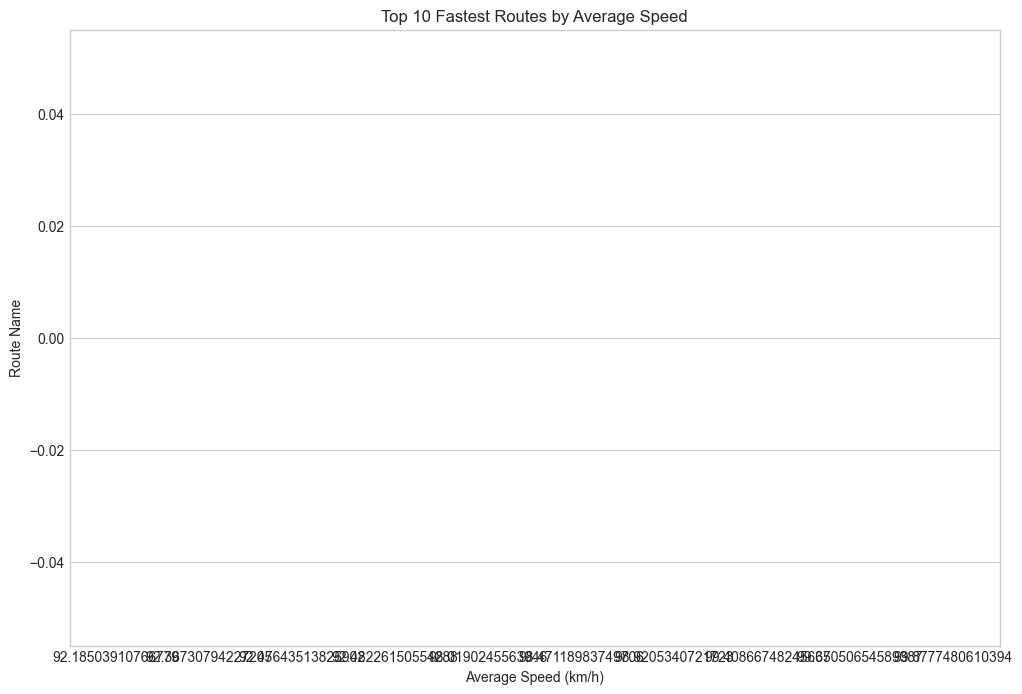


--- Top 10 Slowest Routes (by Average Speed) ---
    route_long_name  avg_speed  total_distance_km
342             NaN       0.01               0.00
788             NaN       0.01               0.00
509             NaN       0.01               0.00
569             NaN       0.02               0.00
347             NaN       0.03               0.00
417             NaN       0.03               0.00
136             NaN       0.04               0.00
221             NaN       0.05               0.00
341             NaN       0.05               0.00
233             NaN       0.06               0.01


C:\Users\Gourav Sahu\AppData\Local\Temp\ipykernel_41832\471608171.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_speed', y='route_long_name', data=slowest_routes, palette='plasma')


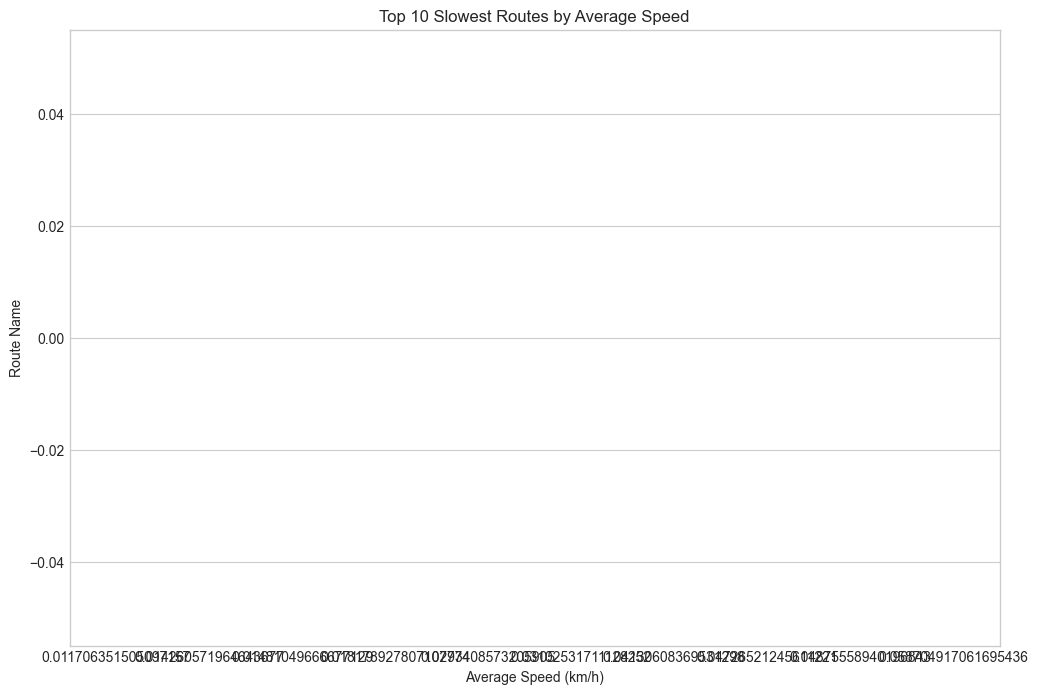

In [82]:
# --- Block 2: Analyze and Visualize Route Performance ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

if 'df_moves' in locals() and not df_moves.empty:
    print("\nAnalyzing overall route performance...")
    
    # Calculate average speed and total distance traveled for each route
    route_performance = df_moves.groupby('route_id').agg(
        avg_speed=('actual_speed_kmh', 'mean'),
        median_speed=('actual_speed_kmh', 'median'),
        max_speed=('actual_speed_kmh', 'max'),
        total_distance_km=('dist_delta', 'sum')
    ).reset_index()
    
    # Convert distance to km
    route_performance['total_distance_km'] /= 1000
    
    # Merge with routes.txt to get route names
    route_performance = pd.merge(route_performance, df_routes[['route_id', 'route_long_name']], on='route_id', how='left')
    
    print("\n--- Top 10 Fastest Routes (by Average Speed) ---")
    fastest_routes = route_performance.sort_values('avg_speed', ascending=False).head(10)
    print(fastest_routes[['route_long_name', 'avg_speed', 'total_distance_km']].round(2))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='avg_speed', y='route_long_name', data=fastest_routes, palette='viridis')
    plt.title('Top 10 Fastest Routes by Average Speed')
    plt.xlabel('Average Speed (km/h)')
    plt.ylabel('Route Name')
    plt.show()

    print("\n--- Top 10 Slowest Routes (by Average Speed) ---")
    slowest_routes = route_performance.sort_values('avg_speed', ascending=True).head(10)
    print(slowest_routes[['route_long_name', 'avg_speed', 'total_distance_km']].round(2))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='avg_speed', y='route_long_name', data=slowest_routes, palette='plasma')
    plt.title('Top 10 Slowest Routes by Average Speed')
    plt.xlabel('Average Speed (km/h)')
    plt.ylabel('Route Name')
    plt.show()

else:
    print("\n❌ No valid vehicle movements found to analyze.")

# Other Summary

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# --- Block 1: Basic Data Characterization ---

print("Analyzing the characteristics of the real-time GPS data...")

# Load the real-time vehicle positions data
df_positions = pd.read_csv("vehicle_positions_archive2.csv")

# Convert timestamp to a readable format
df_positions['datetime'] = pd.to_datetime(df_positions['timestamp'], unit='s')

# --- Key Metrics ---
num_vehicles = df_positions['vehicle_id'].nunique()
num_trips = df_positions['trip_id'].nunique()
start_time = df_positions['datetime'].min()
end_time = df_positions['datetime'].max()
duration = end_time - start_time

print(f"\n--- Dataset Summary ---")
print(f"Unique Vehicles: {num_vehicles}")
print(f"Unique Trips: {num_trips}")
print(f"Time Range: From {start_time} to {end_time}")
print(f"Total Duration Covered: {duration}")

Analyzing the characteristics of the real-time GPS data...

--- Dataset Summary ---
Unique Vehicles: 3904
Unique Trips: 9361
Time Range: From 2025-09-11 09:27:14 to 2080-01-06 00:06:07
Total Duration Covered: 19839 days 14:38:53



Analyzing the frequency of GPS pings...

--- GPS Ping Frequency Stats (in minutes) ---
count      168306.00
mean         1153.09
std        179188.44
min             0.00
25%             0.00
50%             0.00
75%             0.18
max      28566359.17
Name: time_delta_seconds, dtype: float64


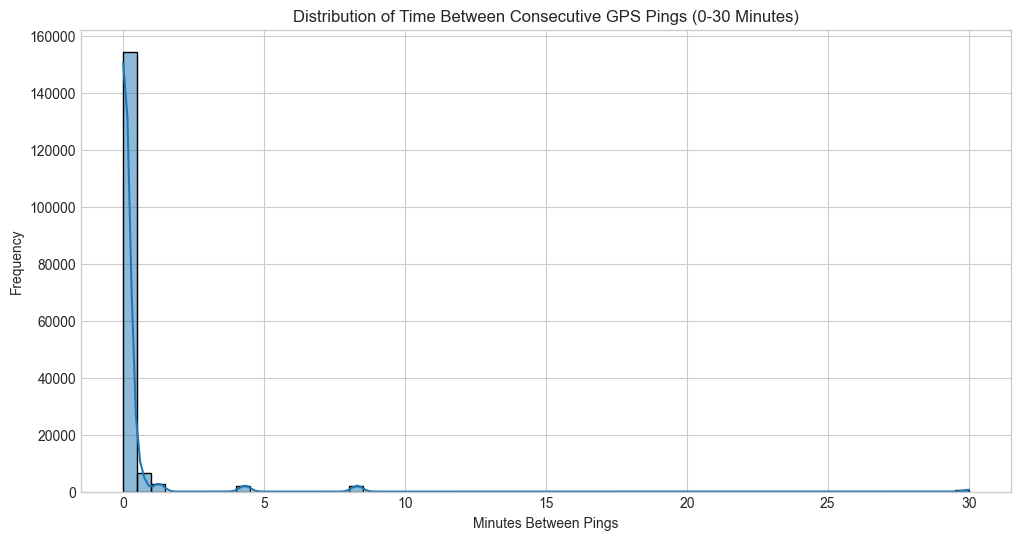

In [87]:
# --- Block 2: Quantifying Data Sparsity ---

print("\nAnalyzing the frequency of GPS pings...")

# Sort the data to calculate time differences correctly
df_positions = df_positions.sort_values(['trip_id', 'timestamp'])

# Calculate time delta between consecutive pings for the same trip
df_positions['time_delta_seconds'] = df_positions.groupby('trip_id')['timestamp'].diff()

# --- Analysis of Ping Frequency ---
# We'll look at the distribution of these time deltas
ping_frequency_minutes = df_positions['time_delta_seconds'] / 60
print("\n--- GPS Ping Frequency Stats (in minutes) ---")
print(ping_frequency_minutes.describe().round(2))

# Visualize the distribution
plt.figure(figsize=(12, 6))
# We'll filter for a reasonable range to avoid extreme outliers skewing the plot
sns.histplot(ping_frequency_minutes.dropna().clip(0, 30), bins=60, kde=True)
plt.title('Distribution of Time Between Consecutive GPS Pings (0-30 Minutes)')
plt.xlabel('Minutes Between Pings')
plt.ylabel('Frequency')
plt.show()

In [85]:
# --- Block 3: Visualizing Bus Activity Hotspots ---
# For this visualization, you might need to install the 'folium' library
# !pip install folium

import folium
from folium.plugins import HeatMap

print("\nGenerating a heatmap of bus activity...")

# Use a sample of the data to avoid crashing the map with too many points
# You can increase the sample size if your machine can handle it
sample_df = df_positions.sample(n=min(50000, len(df_positions)))

# Create a base map centered on the data
map_center = [sample_df['latitude'].mean(), sample_df['longitude'].mean()]
bus_map = folium.Map(location=map_center, zoom_start=11)

# Create a list of coordinate pairs for the heatmap
heat_data = [[point.latitude, point.longitude] for index, point in sample_df.iterrows()]

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(bus_map)

# Save the map to an HTML file
bus_map.save("bus_activity_heatmap.html")

print("✅ Heatmap saved to 'bus_activity_heatmap.html'. Open this file in your browser to view it.")


Generating a heatmap of bus activity...
✅ Heatmap saved to 'bus_activity_heatmap.html'. Open this file in your browser to view it.


Investing the time issue 

Investigating the distribution of timestamps...


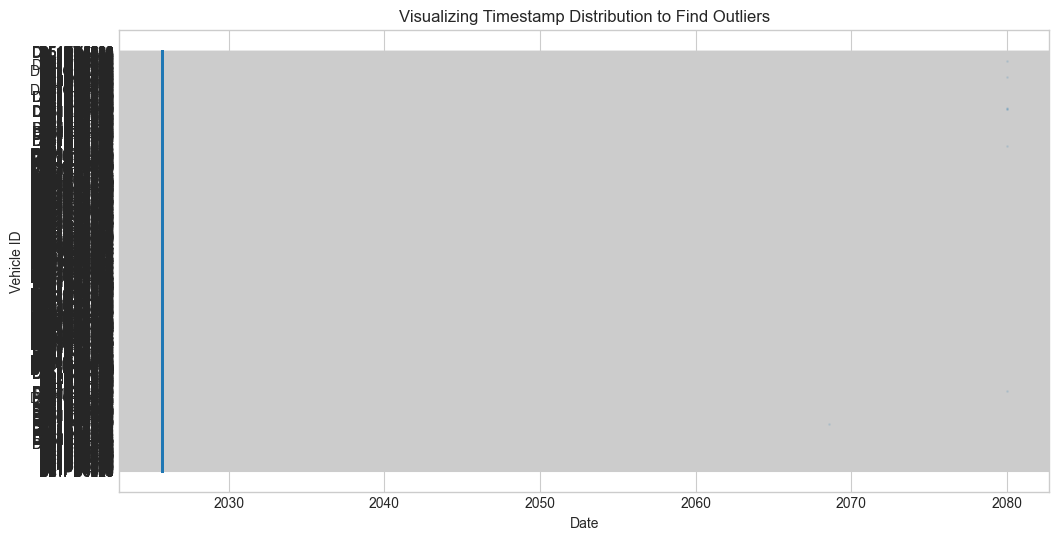


Earliest Timestamp: 2025-09-11 09:27:14
Latest Timestamp:   2080-01-06 00:06:07


In [90]:
# --- Block 1A: Diagnosing Timestamp Outliers ---

print("Investigating the distribution of timestamps...")

# Ensure the datetime column exists
if 'datetime' not in df_positions.columns:
    df_positions['datetime'] = pd.to_datetime(df_positions['timestamp'], unit='s')

# Create a simple scatter plot of dates
# The outliers will be clearly visible, far away from the main cluster of data
plt.figure(figsize=(12, 6))
plt.scatter(df_positions['datetime'], df_positions['vehicle_id'], s=1, alpha=0.1)
plt.title('Visualizing Timestamp Distribution to Find Outliers')
plt.xlabel('Date')
plt.ylabel('Vehicle ID')
plt.grid(True)
plt.show()

# Print the earliest and latest timestamps to confirm the issue numerically
print(f"\nEarliest Timestamp: {df_positions['datetime'].min()}")
print(f"Latest Timestamp:   {df_positions['datetime'].max()}")

In [89]:
# --- Block 1B: The Solution - Filtering Outliers ---

print("Filtering out rows with erroneous timestamps...")

# Keep only the rows with a plausible timestamp.
# We'll assume any data after the end of 2025 is an error.
initial_rows = len(df_positions)
df_positions_cleaned = df_positions[df_positions['datetime'].dt.year <= 2025]

print(f"Removed {initial_rows - len(df_positions_cleaned)} rows with bad timestamps.")

# --- Recalculate the Summary on the Cleaned Data ---
num_vehicles = df_positions_cleaned['vehicle_id'].nunique()
num_trips = df_positions_cleaned['trip_id'].nunique()
start_time = df_positions_cleaned['datetime'].min()
end_time = df_positions_cleaned['datetime'].max()
duration = end_time - start_time

print(f"\n--- CORRECTED Dataset Summary ---")
print(f"Unique Vehicles: {num_vehicles}")
print(f"Unique Trips: {num_trips}")
print(f"Time Range: From {start_time} to {end_time}")
print(f"Total Duration Covered: {duration}")

Filtering out rows with erroneous timestamps...
Removed 8 rows with bad timestamps.

--- CORRECTED Dataset Summary ---
Unique Vehicles: 3904
Unique Trips: 9361
Time Range: From 2025-09-11 09:27:14 to 2025-09-13 06:06:57
Total Duration Covered: 1 days 20:39:43



Analyzing the frequency of GPS pings on the cleaned data...

--- CORRECTED GPS Ping Frequency Stats (in minutes) ---
count    168298.00
mean          0.80
std          22.24
min           0.00
25%           0.00
50%           0.00
75%           0.18
max        2666.03
Name: time_delta_seconds, dtype: float64


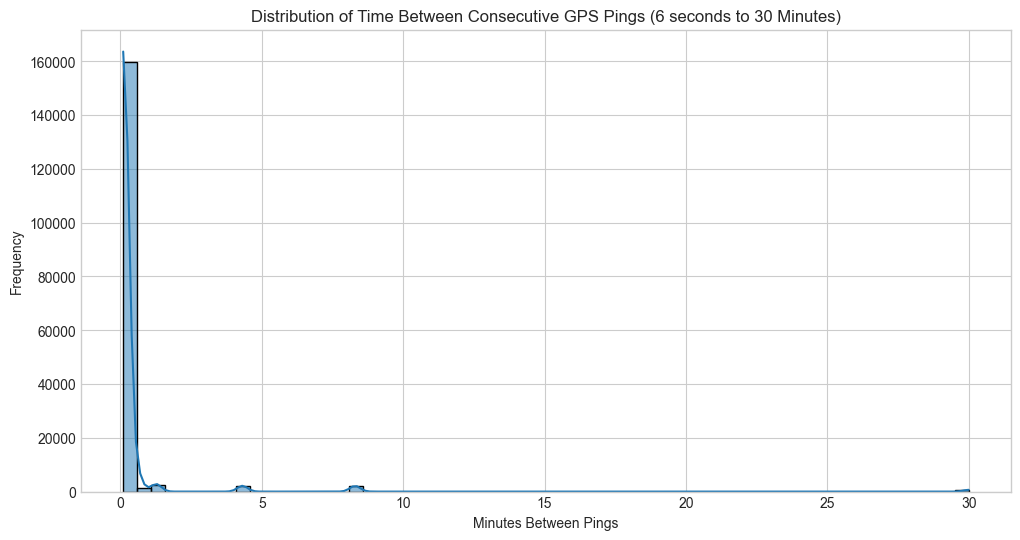

In [91]:
# --- Block 2: Quantifying Data Sparsity (on Cleaned Data) ---

print("\nAnalyzing the frequency of GPS pings on the cleaned data...")

# Use the cleaned dataframe
df_to_analyze = df_positions_cleaned

# Sort the data to calculate time differences correctly
df_to_analyze = df_to_analyze.sort_values(['trip_id', 'timestamp'])

# Calculate time delta between consecutive pings for the same trip
df_to_analyze['time_delta_seconds'] = df_to_analyze.groupby('trip_id')['timestamp'].diff()

# --- Analysis of Ping Frequency ---
ping_frequency_minutes = df_to_analyze['time_delta_seconds'] / 60
print("\n--- CORRECTED GPS Ping Frequency Stats (in minutes) ---")
print(ping_frequency_minutes.describe().round(2))

# Visualize the distribution
plt.figure(figsize=(12, 6))

# We'll filter for a reasonable range to avoid extreme outliers
meaningful_pings = ping_frequency_minutes.dropna().clip(0.1, 30) # Start from 0.1 mins (6 seconds)
if not meaningful_pings.empty:
    sns.histplot(meaningful_pings, bins=60, kde=True)
    plt.title('Distribution of Time Between Consecutive GPS Pings (6 seconds to 30 Minutes)')
    plt.xlabel('Minutes Between Pings')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("\nNo meaningful time gaps between pings were found in the 6 sec - 30 min range.")

In [92]:
# --- Block 3: Visualizing Bus Activity Hotspots (on Cleaned Data) ---
# For this visualization, you might need to install the 'folium' library
# !pip install folium

import folium
from folium.plugins import HeatMap

print("\nGenerating a heatmap of bus activity from the cleaned data...")

# Use a sample of the cleaned data
sample_df = df_positions_cleaned.sample(n=min(50000, len(df_positions_cleaned)))

# Create a base map centered on the data
map_center = [sample_df['latitude'].mean(), sample_df['longitude'].mean()]
bus_map = folium.Map(location=map_center, zoom_start=11)

# Create a list of coordinate pairs for the heatmap
heat_data = [[point.latitude, point.longitude] for index, point in sample_df.iterrows()]

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(bus_map)

# Save the map to an HTML file
bus_map.save("bus_activity_heatmap_cleaned.html")

print("✅ Heatmap saved to 'bus_activity_heatmap_cleaned.html'. Open this file in your browser to view it.")


Generating a heatmap of bus activity from the cleaned data...
✅ Heatmap saved to 'bus_activity_heatmap_cleaned.html'. Open this file in your browser to view it.
